In [1]:
%matplotlib inline
import glob
import h5py
from matplotlib import pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import skopi as sk
import pickle

import time
import numpy as np
from numpy.linalg import norm
import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output
from sklearn.decomposition import PCA, IncrementalPCA
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import rotate

import os
import sys
sys.path.append('../src/')

In [2]:
spi_dataset="/scratch/apeck/cmtip/3iyf_dp2_5k/3iyf_sim.h5"
spi_data = h5py.File(spi_dataset, 'r')
geom_path=f'/sdf/home/a/anassb/skopi/examples/input/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'
det = sk.PnccdDetector(geom=geom_path)

In [3]:
spi_data.keys()

<KeysViewHDF5 ['intensities', 'orientations', 'pixel_index_map', 'pixel_position_reciprocal', 'volume']>

In [4]:
n_images = spi_data['intensities'].shape[0]
d1, d2 = (512, 512)
n_batches = 5
batch_size = n_images // n_batches
batch_index = np.arange(n_images).reshape(n_batches, batch_size)

n_comp = 50

sub_ratio = 1
sub_d1 = d1 // sub_ratio
sub_d2 = d2 // sub_ratio

sub_index_1 = sub_ratio * np.arange(sub_d1)
sub_index_2 = sub_ratio * np.arange(sub_d2)

## Storing the iPCA :

It can be done two ways : pickling the whole PCA object or saving only its "mean_", "components_" and "singular_values_" parameters. This second option is cheaper in terms of memory, but requires that all next operations be done manually instead of calling IncrementalPCA methods.

In [5]:
save_path = '../save/ipca_cdi_process'

if not os.path.exists(save_path) :
    ipca = IncrementalPCA(n_components=n_comp)

    for index in tqdm(batch_index) :
        batch = spi_data['intensities'][index].reshape(batch_size, d1, d2)[:, sub_index_1][:,:, sub_index_2]
        ipca.partial_fit(batch.reshape(batch_size, sub_d1 * sub_d2))

    pca_file = open(save_path,'wb')
    pickle.dump(ipca, pca_file)
    pca_file.close()

else :
    pca_file = open(save_path,'rb')
    ipca = pickle.load(pca_file)
    pca_file.close()

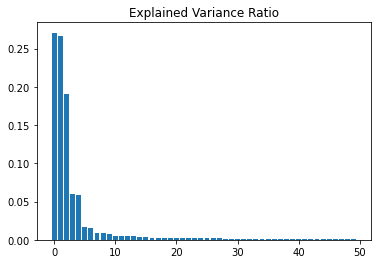

In [6]:
def EVRplot(pca) :   
    fig = plt.figure(figsize=(6, 4))
    plt.bar(np.arange(n_comp), pca.explained_variance_ratio_)
    plt.title('Explained Variance Ratio')
    plt.show()
    return fig

evr = EVRplot(ipca)
evr.savefig('../images/cdi_evr.png')

In [6]:
coordinates = ipca.transform(spi_data['intensities'][:, :, sub_index_1][:, :, :, sub_index_2].reshape(n_images, sub_d1 * sub_d2))
eigenimages = ipca.components_.reshape(n_comp, sub_d1, sub_d2)

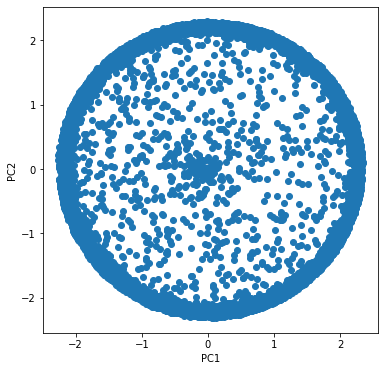

In [8]:
def PCplot(pca, pc_i, pc_j) :
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(coordinates[:, pc_i], coordinates[:, pc_j])
    plt.xlabel(f'PC{pc_i + 1}')
    plt.ylabel(f'PC{pc_j + 1}')
    plt.show()
    return fig

pc12 = PCplot(ipca, 0, 1)
pc12.savefig('../images/cdi_ipca_pc12.png')

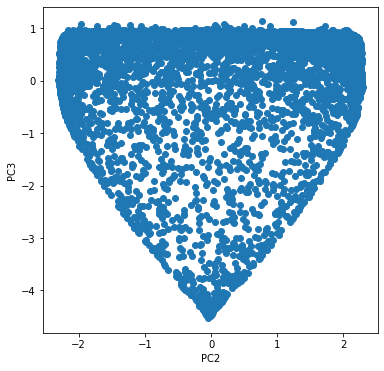

In [9]:
pc23 = PCplot(ipca, 1, 2)
pc23.savefig('../images/cdi_ipca_pc23.png')

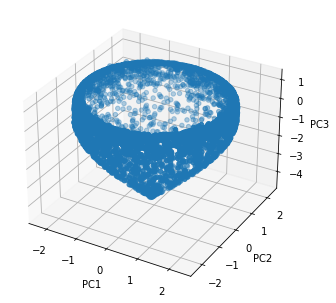

In [10]:
def PCplot3d(pca, pc_i, pc_j, pc_k) :
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(coordinates[:, pc_i], coordinates[:, pc_j], coordinates[:, pc_k])
    ax.set_xlabel(f'PC{pc_i + 1}')
    ax.set_ylabel(f'PC{pc_j + 1}')
    ax.set_zlabel(f'PC{pc_k + 1}')
    plt.show()
    return fig

pc123 = PCplot3d(ipca, 0, 1, 2)
pc123.savefig('../images/cdi_ipca_pc123.png')

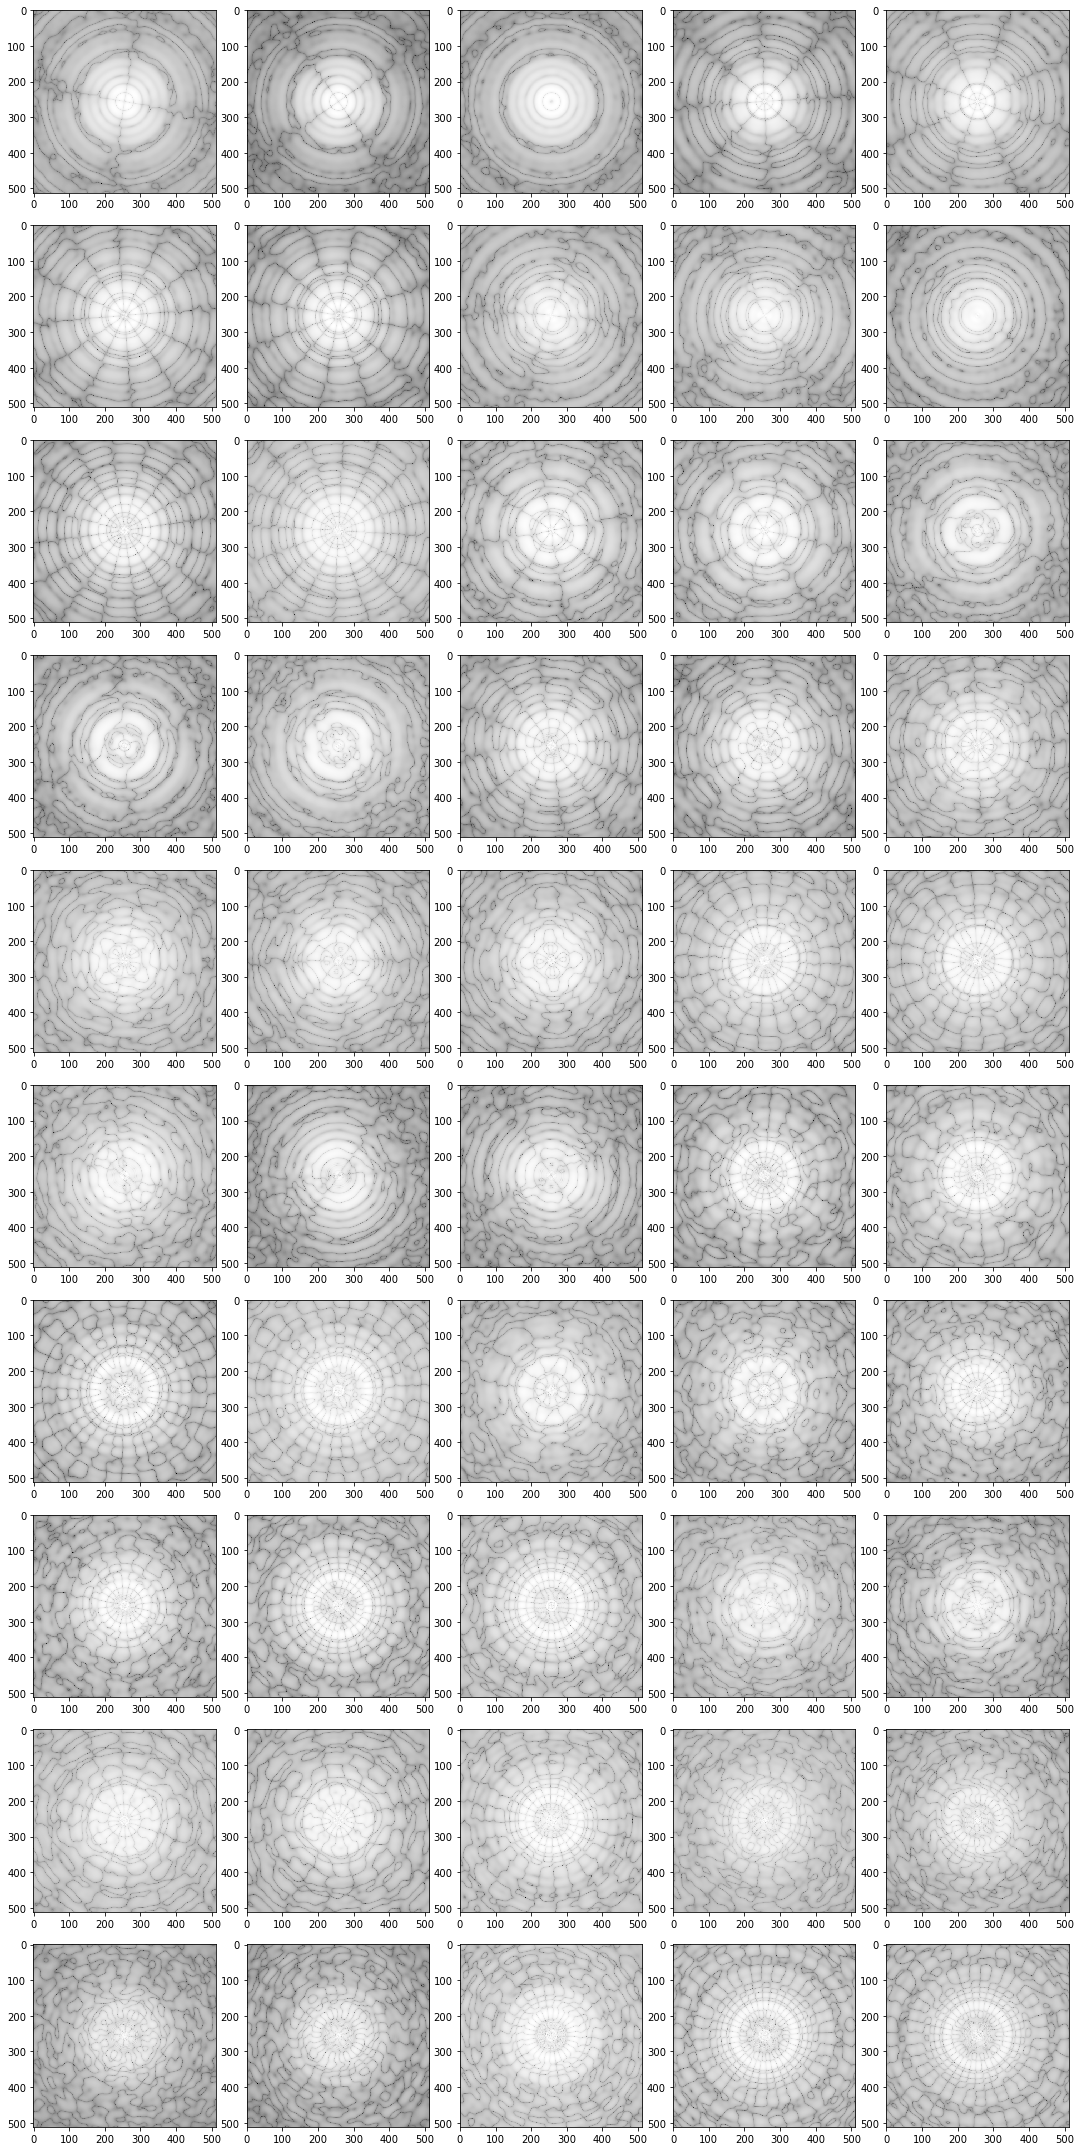

In [11]:
nrows=10
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*(nrows//ncols)))
for i in range(nrows):
    for j in range(ncols):
        image = eigenimages[i*ncols+j]
        axs[i,j].imshow(np.abs(image), norm=LogNorm(), interpolation='none', cmap='Greys_r')
plt.tight_layout()

In [7]:
n_partial = 3
n_plot = 10
spi_mean = ipca.mean_

full_reconstruct = ipca.inverse_transform(coordinates).reshape(n_images, sub_d1, sub_d2)
partial_reconstruct = (np.dot(coordinates[:, :n_partial], ipca.components_[:n_partial]) + ipca.mean_).reshape(n_images, sub_d1, sub_d2)

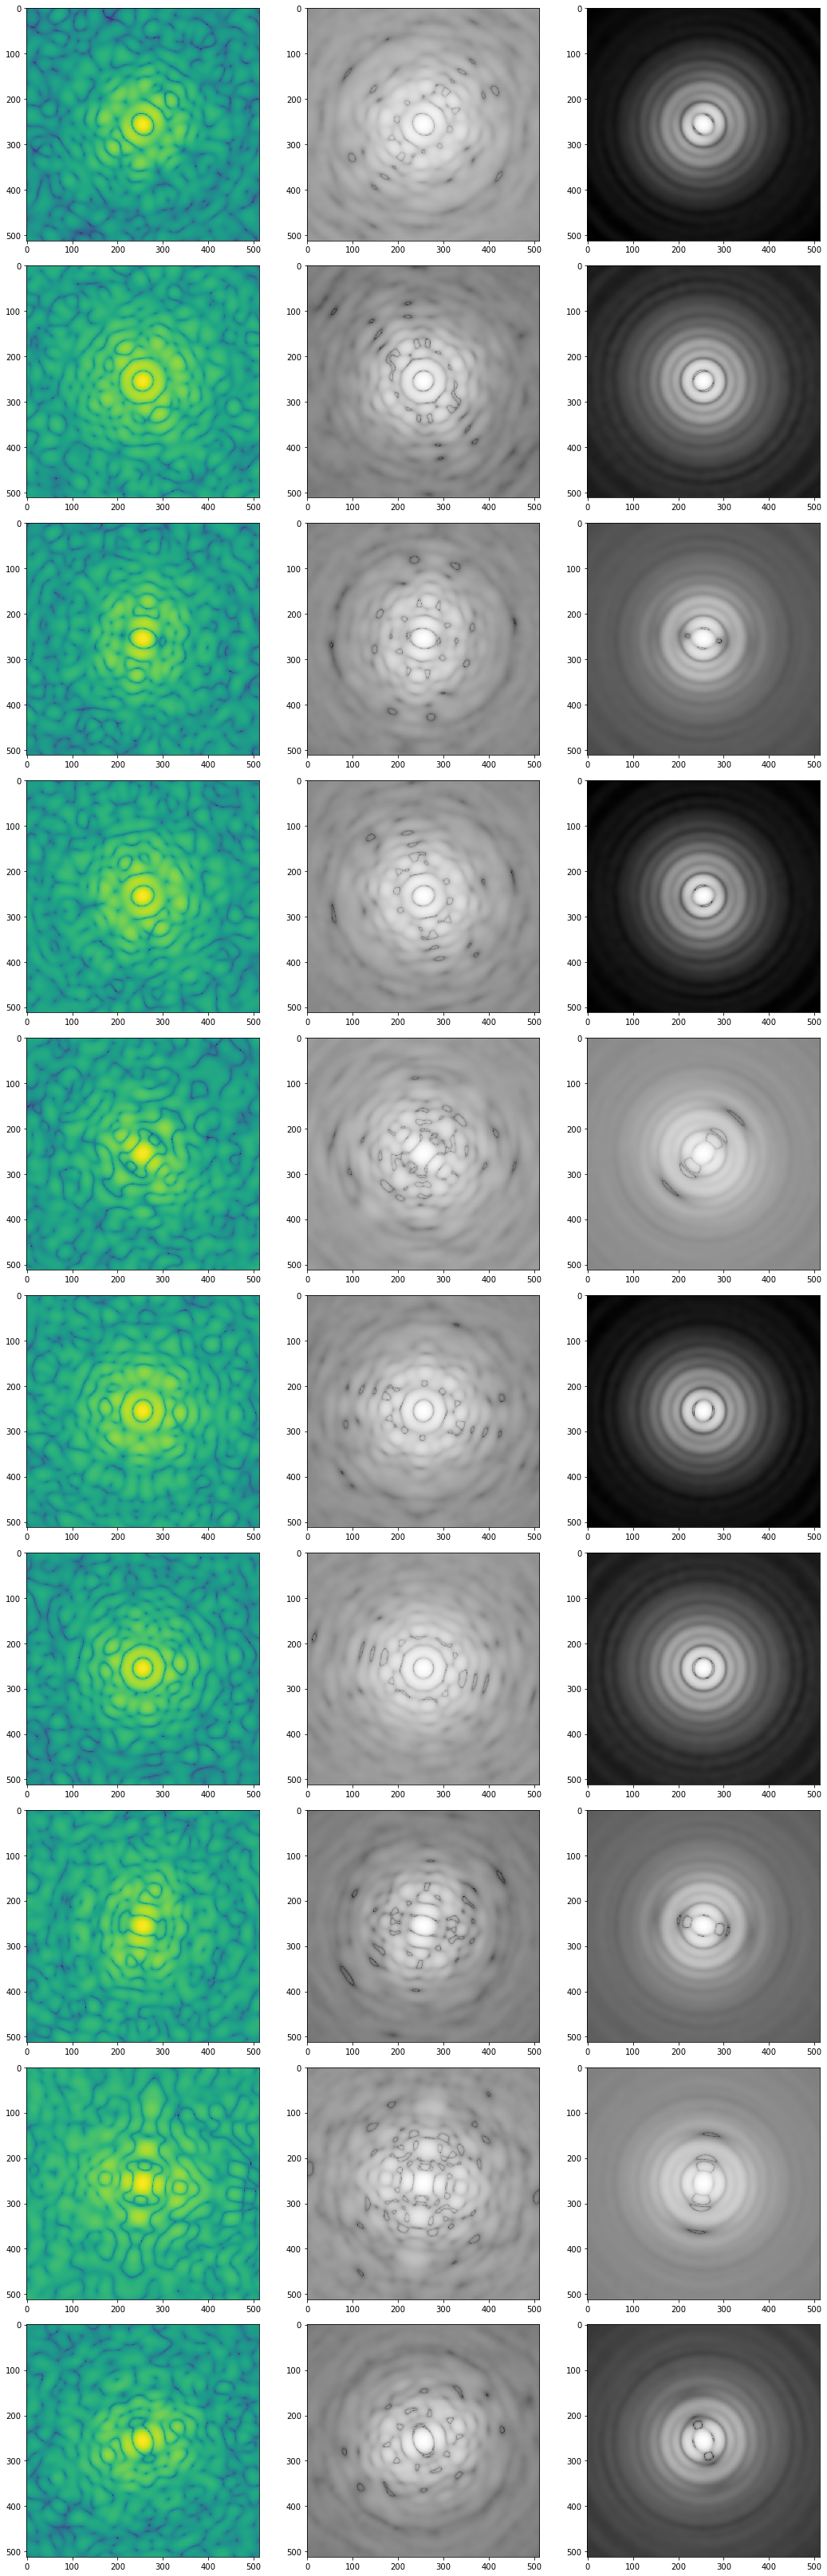

In [9]:
nrows=n_plot
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*(nrows//ncols)))
for i in range(nrows):
    image = spi_data['intensities'][i, 0, sub_index_1][:, sub_index_2]
    fullr = full_reconstruct[i]
    partialr = partial_reconstruct[i]
    axs[i,0].imshow(image, norm=LogNorm(), interpolation='none')
    axs[i,1].imshow(np.abs(fullr), norm=LogNorm(), interpolation='none', cmap='Greys_r')
    axs[i,2].imshow(np.abs(partialr), norm=LogNorm(), interpolation='none', cmap='Greys_r')
plt.tight_layout()
fig.savefig('../images/cdi_reconstructions.png')

In [8]:
n_bins = 20
min_bin = coordinates[:, 2].min()
max_bin = coordinates[:, 2].max()
bins = np.linspace(min_bin, max_bin, n_bins + 1)
bin_indexes = [(coordinates[:, 2] >= bins[i]) * (coordinates[:, 2] < bins[i + 1]) for i in range(n_bins)]

## Bin similarity :

Let $B = \{u_1, \dots , u_d\}$ be a bin, with $u_i$ vectors representing the rotations of the images in the bin such that $||u_i||$ be the angle of the rotation and $\frac{1}{||u_i||} u_i$ its axis.

Let $M$ the correlation matrix of $B$, we measure the similarity of rotation axes in $B$ by :

$$J = \frac{||M||_{L^2}}{d}$$

We thus have $J = 1 \Leftrightarrow M = \begin{bmatrix} 
    1 & \dots & 1 \\
    \vdots & \ddots & \\
    1 &        & 1 
    \end{bmatrix}$
    
We consider $argmax_{u \in B} \sum_{1 \leq i \leq d} \frac{|<u, u_i>|}{||u|| \cdot ||u_i||}$ to be the center axis of $B$.

In [46]:
def as_normrotvec(quat) :
    rotvec = R(quat).as_rotvec()
    return rotvec/norm(rotvec)

def rotvec_cor(r1, r2) :
    return np.abs(r1.dot(r2))

def bin_cor(b) :
    rotvec = [as_normrotvec(x) for x in spi_data['orientations'][:][b]]
    len_bin = len(rotvec)
    cor = np.zeros((len_bin, len_bin))
    for i in range(len_bin) :
        for j in range(len_bin) :
            cor[i, j] = rotvec_cor(rotvec[i], rotvec[j])
    return cor

def find_center_axis(cor) :
    metric = cor.sum(axis=1)
    return np.argmax(metric)
    
def similarity_score(cor) :
    return norm(cor)/len(cor)

def diff_angle(quat1, quat2) :
    r_diff = (R(quat2) * R(quat1).inv()).as_rotvec()
    theta = norm(r_diff)
    if theta <= np.pi / 2 :
        return theta
    return theta - np.pi

In [10]:
cors = [bin_cor(b) for b in bin_indexes]

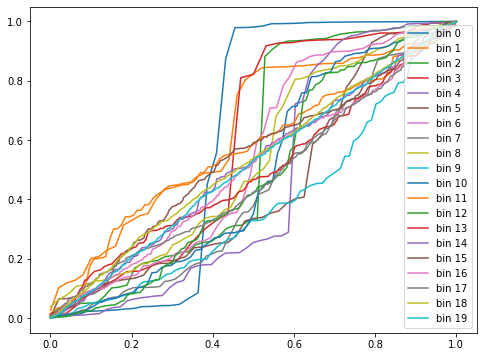

In [71]:
fig = plt.figure(figsize=(8, 6))
for i in range(n_bins) :
    b = bin_indexes[i]
    scal_rotvec = cors[i][0]
    x_bin = np.linspace(0, 1, b.sum())
    plt.plot(x_bin, np.sort(scal_rotvec), label=f"bin {i}")
plt.legend(loc='best')
plt.show()

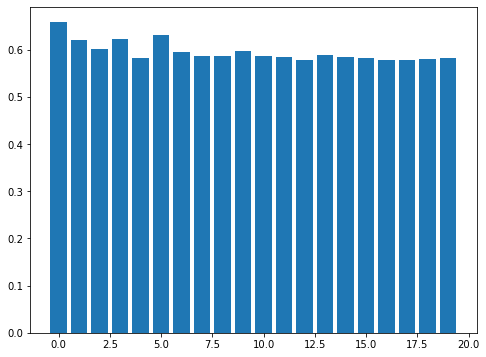

In [11]:
fig = plt.figure(figsize=(8, 6))
similarity_scores = [similarity_score(c) for c in cors]
x_bar = np.arange(n_bins)
plt.bar(x_bar, similarity_scores)
plt.show()

In [47]:
center_axes = [find_center_axis(cor) for cor in cors]
angles = []

for i in range(n_bins) :
    b = bin_indexes[i]
    len_bin = b.sum()
    axis = center_axes[i]
    quats = spi_data['orientations'][:][b]
    quat1 = quats[axis]
    theta = np.zeros(len_bin)
    for j in range(len_bin) :
        quat2 = quats[j]
        theta[j] = diff_angle(quat1, quat2)
    angles.append(theta)

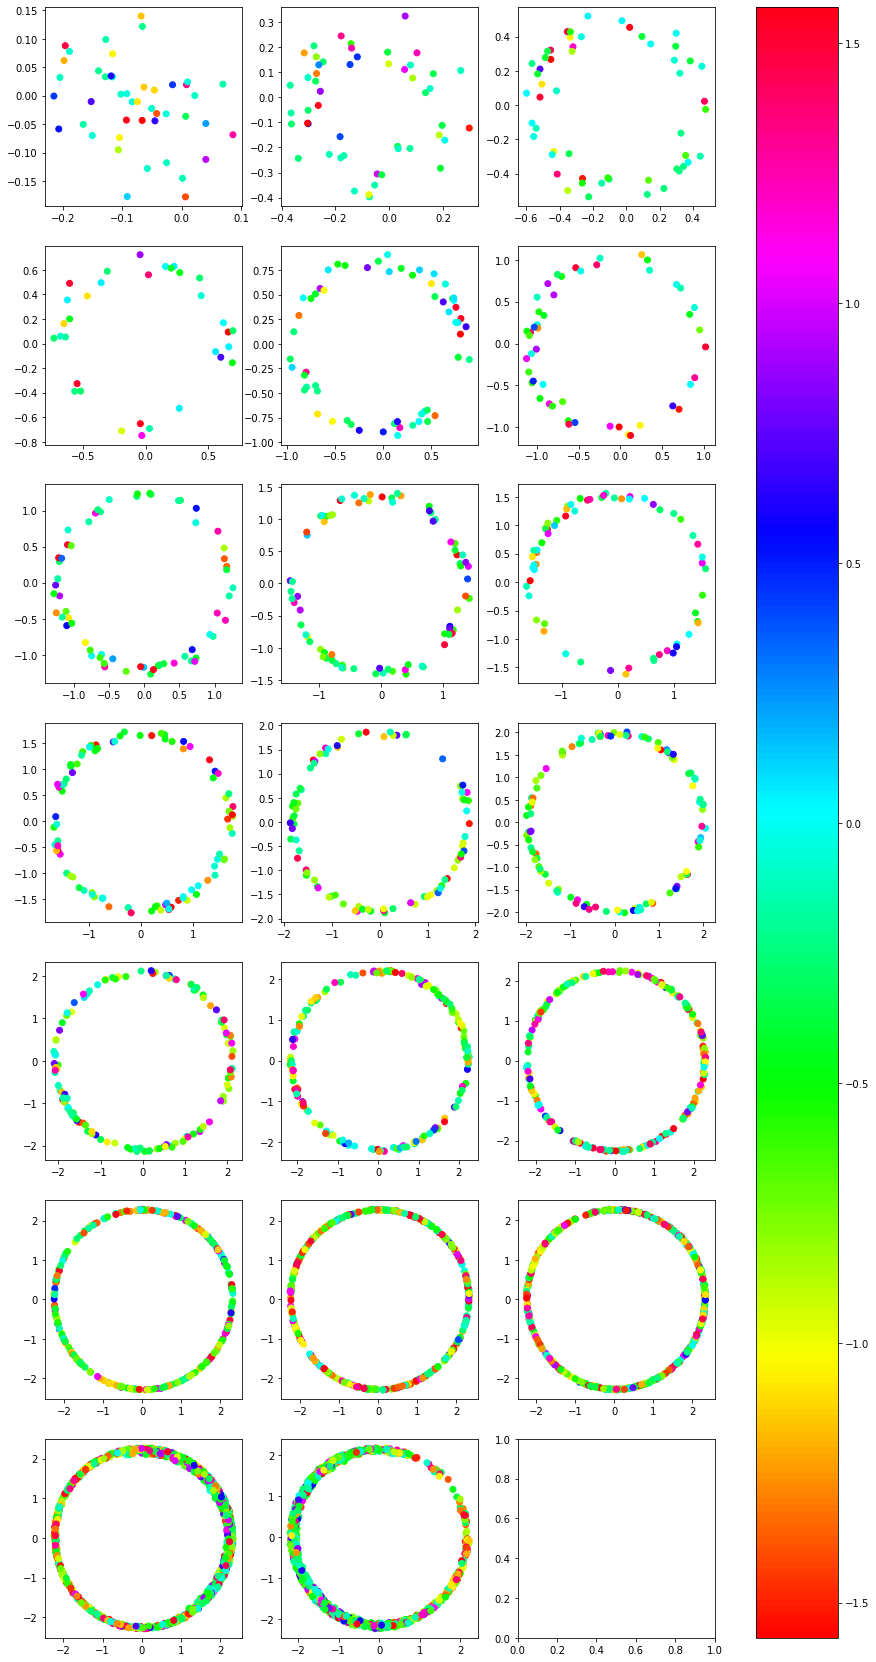

In [52]:
ncols = 3
nrows = int(np.ceil(n_bins/ncols))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*(nrows//ncols)))
for i in range(nrows):
    for j in range(ncols) :
        if i * ncols + j < n_bins :
            b = bin_indexes[i * ncols + j]
            im = axs[i, j].scatter(coordinates[b][:, 0], coordinates[b][:, 1], c=angles[i * ncols + j], cmap='hsv')

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

In [77]:
n_subbins = 5
subbins = np.linspace(-np.pi/2, np.pi/2, n_subbins + 1)
subbin_indexes = np.array([[(angles[j] >= subbins[i]) * (angles[j] < subbins[i + 1]) for i in range(n_subbins)] for j in range(n_bins)], dtype=object)

In [94]:
def angle_from_coord(x, y) :
    return np.arctan(y/x) 

In [91]:
subbin_cone_angle = np.array([[coordinates[bin_indexes[j]][subbin_indexes[j,i], 3].mean() for i in range(n_subbins)] for j in range(n_bins)], dtype=object)
subbin_depth = np.array([[coordinates[bin_indexes[j]][subbin_indexes[j,i], 3].mean() for i in range(n_subbins)] for j in range(n_bins)], dtype=object)

subbin_angle = np.array([[angles[j][subbin_indexes[j, i]].mean() for i in range(n_subbins)] for j in range(n_bins)], dtype=object)

subbin_cone_depth = np.zeros(n_bins, n_subbins)
subbin_cone_angle = np.zeros(n_bins, n_subbins)

subbin_angle = np.zeros(n_bins, n_subbins)

for i in range(n_bins) :
    for j in range(n_subbins) :
        subbin_angle[i, j] = angles[i][subbin_indexes[i, j]].mean()
        
        subbin_cone_depth[i, j] = coordinates[bin_indexes[i]][subbin_indexes[i, j], 3].mean()
        subbin_cone_angle[i, j] = np.arctan(coordinates[bin_indexes[j]][subbin_indexes[j,i], 3])

In [93]:
subbin_depth.shape

(20, 5)

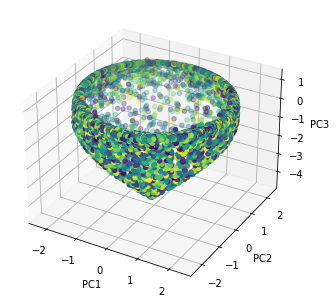

In [41]:
fig = plt.figure()
ax = Axes3D(fig)
cm = plt.get_cmap('viridis')

for b in bin_indexes :
    rot = []
    ref = R(spi_data['orientations'][:][b][0])
    for x in spi_data['orientations'][:][b] :
        rot.append((R(x) * ref.inv()).as_euler('zyx', degrees=True)[2]) 
        
    ax.scatter(coordinates[b, 0], coordinates[b, 1], coordinates[b, 2], c=rot, cmap=cm)

ax.set_xlabel(f'PC{1}')
ax.set_ylabel(f'PC{2}')
ax.set_zlabel(f'PC{3}')
plt.show()

In [ ]:
averages = []

for b in bin_indexes :
    ref_img = spi_data['intensities'][:][b][0]
    ref_rot = R(spi_data['orientations'][:][b][0])
    bin_img = [ref_img]
    for i in range(1, b.sum()) :
        rot = R(spi_data['orientations'][:][b][i])
        diff_rot = (rot * ref_rot.inv()).as_euler('zyx', degrees=True)[2]
        img = rotate(spi_data['intensities'][:][b][i], diff_rot, reshape=False)
        bin_img.append(img)
    averages.append()

In [ ]:
nrows = n_bins
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 9*(nrows//ncols)))
for i in range(nrows):
    b = bin_indexes[i]
    original = spi_data['intensities'][:][b][0]
    avg = averages[i]
    axs[i,0].imshow(original, interpolation='none')
    axs[i,1].imshow(avg, interpolation='none', cmap='Greys_r')
plt.tight_layout()

colore par la norme des quaternions

retrouver vecteur principal

norme minimale

moyenne : tourne puis somme

2 angles : angle polaire le long de la bin
    
tenir fred au courant

# spi :

vérifier cône sur autres datasets

prendre reférences sur la même ligne du cône

lier angle image et angle/position cône (voir papier : plot)

paralléliser pca

creuser théorie variétés

comparer visuellement images d'1 même bin

slicer verticalement

rotation SO2

trajectoire sur le cône d'1 même image qu'on tourne

# cryoem : 

extraire angles et defocus (quantifier)

appliquer méthodes non-linéaires sur 1res composantes pca pour retrouver angles et defocus

documenter le notebook